In [1]:
import numpy as np
from scipy import fft as fft
from scipy.sparse.linalg import LinearOperator
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'

class Operator(LinearOperator):
    def __init__(self, N=500, L=1):
        self.L = L
        self.N = N
        self.shape = (self.N,self.N)
        self.x = np.linspace(0, self.L, num=self.N, endpoint=False)

    
class FourierMultiplier(Operator):

    def __init__(self, transform='dct', **kwargs):
        super().__init__(**kwargs)
        self.dtype = None
        self.freqs = fft.fftfreq(self.N, d=self.L/self.N)
        self.multiplier = None ## Need to implement this on particular case
        self.transform = transform
        if self.transform == 'dct':
            self.fwd = fft.dct
            self.inv = fft.idct
            self.func = np.cos
        elif self.transform == 'dst':
            self.fwd = fft.dst
            self.inv = fft.idst
            self.func = np.sin
        elif self.transform == 'fft':
            self.fwd = np.fft.fft
            self.inv = np.fft.ifft
            self.func = lambda x: np.exp(2j*x)
            
    def eigenfunction(self, i):
        return lambda x: self.func(np.pi*self.freqs[i]*x)
        
    def eigenvector(self, i):
        v = self.eigenfunction(i)(self.x)
        return v / np.linalg.norm(v)
    
    def to_freq_domain(self, u, axis=-1):
        return self.fwd(u, axis=axis)/np.sqrt(self.N)
    
    def to_time_domain(self, u, axis=-1):
        return self.inv(u, axis=axis) * np.sqrt(self.N)
    
    def coeff2u(self, coeff):
        res = sum(coeff[i]*self.eigenfunction(i)(self.x) for i in np.where(np.abs(coeff) > 1e-5)[0])
        return res    
    
    def _matvec(self, v):
        return self(np.squeeze(v))
    
    def __call__(self, v, mult=None):
        if mult is None:
            mult = self.multiplier
        v_hat = self.to_freq_domain(v)
        Av_hat = v_hat * mult
        Av = self.to_time_domain(Av_hat) 
        return Av + np.mean(v)

    def random(self, return_coeffs=False, beta=1.137):
        if self.transform == 'fft':
            coeffs = np.random.randn(self.N, 2).view(np.complex128) 
            coeffs = np.squeeze(coeffs)
        else:
            coeffs = np.random.randn(self.freqs.size)
        coeffs /= (np.arange(coeffs.size)+1)**beta
        coeffs[0] = 0
        
        u0 = self.coeff2u(coeffs) 
        return u0, coeffs if return_coeffs else u0 
    
    @property
    def matrix(self):
        M = np.diag(self.multiplier) if len(self.multiplier.shape) == 1 else self.multiplier
        M = self.inv(M)
        M = M.conjugate().T
        M = self.inv(M).conjugate().T
        return M
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return 'Generic Fourier multiplier'
    
## Forward Operator
class Heat(FourierMultiplier):
    def __init__(self, time, alpha=1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.time = time
        self.multiplier = np.exp(-self.alpha * np.pi**2 * self.time * self.freqs**2)
          
    def __str__(self):
        return f'Heat operator alpha {alpha} time {time}'

    
class Laplacian(FourierMultiplier): ## Actually, negative Laplacian
    def __init__(self, gamma, **kwargs):
        super().__init__(**kwargs)
        multiplier = np.power(np.pi**2 * self.freqs**2, gamma)
        inv_mult = np.power(np.pi**2 * self.freqs**2, -gamma)
        ind = (multiplier < 1e-4) | (inv_mult < 1e-4) #| np.isnan(multiplier) | np.isnan(inv_mult) | (multiplier > 1e4) | (inv_mult > 1e4)
        ind[0] = True
        #ind[-1] = True
        multiplier[ind] = 0
        self.multiplier = multiplier
        inv_mult[ind] = 0
        self.inv_mult = inv_mult
        self.gamma = gamma
        self.kwargs = kwargs
        self.ind = ind
        
    @property
    def inverse(self):
        return Laplacian(gamma=-self.gamma, N=self.N, L=self.L)
    
    def __str__(self):
        return '$(-\Delta)^{' + str(self.gamma) + '}$'
    
    

In [2]:
class PointObservation(FourierMultiplier):
    def __init__(self, meas=[], **kwargs):
        super().__init__(**kwargs)
        self.meas = np.array(meas)
        self.size = len(meas)
        self.multiplier = np.zeros((self.size, self.N), dtype=np.complex128)
        for k in range(self.N):
            self.multiplier[:,k] = self.eigenfunction(k)(self.meas)/np.sqrt(self.N)
        
    def __call__(self, v):
        vhat = self.to_freq_domain(v)
        return np.einsum('ij, j -> i', self.multiplier, vhat)
                
        
class DiagObservation(FourierMultiplier):
    def __init__(self, singular_values, random_U=False, **kwargs):
        super().__init__(**kwargs)
        singular_values = np.array(singular_values)
        assert len(singular_values.shape) == 1
        self.multiplier = np.zeros((singular_values.shape[0], self.N))
        np.fill_diagonal(self.multiplier, singular_values)
        if random_U:
            H = np.random.randn(singular_values.shape[0], singular_values.shape[0])
            Q, R = np.linalg.qr(H) # From https://stackoverflow.com/questions/38426349/how-to-create-random-orthonormal-matrix-in-python-numpy
            Q = np.vdot(Q, np.diag(np.sign(np.diag(R))))
            self.multiplier = np.dot(Q, self.multiplier)
        O = self.to_time_domain(self.multiplier)
        Ostar = O.T.conj()
        self.OstarO = np.dot(Ostar, O)

<ipython-input-1-a78f94a5409c>:110: RuntimeWarning: divide by zero encountered in power
  multiplier = np.power(np.pi**2 * self.freqs**2, gamma)
<ipython-input-1-a78f94a5409c>:111: RuntimeWarning: divide by zero encountered in power
  inv_mult = np.power(np.pi**2 * self.freqs**2, -gamma)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-1-a78f94a5409c>:111: RuntimeWarning: divide by zero encountered in power
  inv_mult = np.power(np.pi**2 * self.freqs**2, -gamma)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dt

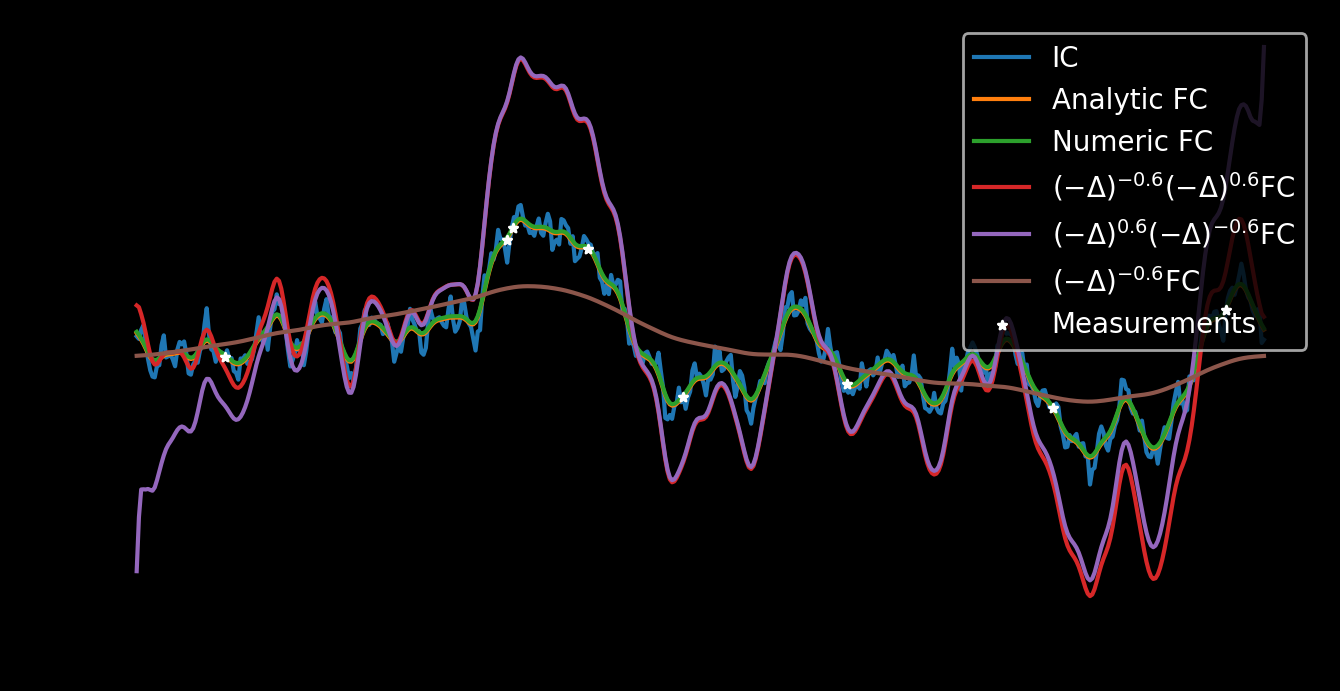

In [14]:
N = 500
L = 3
time = 1e-3
alpha = 0.6
gamma = -.6
beta = 1
transform = 'fft'
sig = 0.01


fwd = Heat(N=N, L=L, alpha=alpha, time=time, transform=transform)
prior = Laplacian(gamma=gamma, N=N, L=L, transform=transform)
obs = PointObservation(meas=[0.2356323, 0.9822345, 1.451242, 1.886632215, 2.43244, 2.89235633, 1, 1.2], L=L, N=N, transform=transform)

# IC
u0, coeffs0 = fwd.random(return_coeffs=True, beta=beta)

# Analytic
coeffsT = coeffs0 * fwd.multiplier
uT = fwd.coeff2u(coeffsT)

# Numeric solution
uT_num = fwd(u0)

plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='Analytic FC')
plt.plot(fwd.x, uT_num.real+0.02, label='Numeric FC')
plt.plot(prior.x, prior(prior.inverse(uT))-0.02, label=str(prior) + str(prior.inverse) + 'FC')
plt.plot(prior.x, prior.inverse(prior(uT))+0.01, label= str(prior.inverse) + str(prior) + 'FC')
plt.plot(prior.x, prior(uT), label= str(prior) + 'FC')
#plt.plot(prior.x, prior.inverse(uT), label= prior.inv_str + 'FC')
plt.scatter(obs.meas, obs(uT).real, label='Measurements', marker='*', s =10, color='w', zorder=10)

plt.legend()
#plt.close()

O (250, 500) F (500,) Sigma (500,) A (250, 500) M (250, 250)


/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


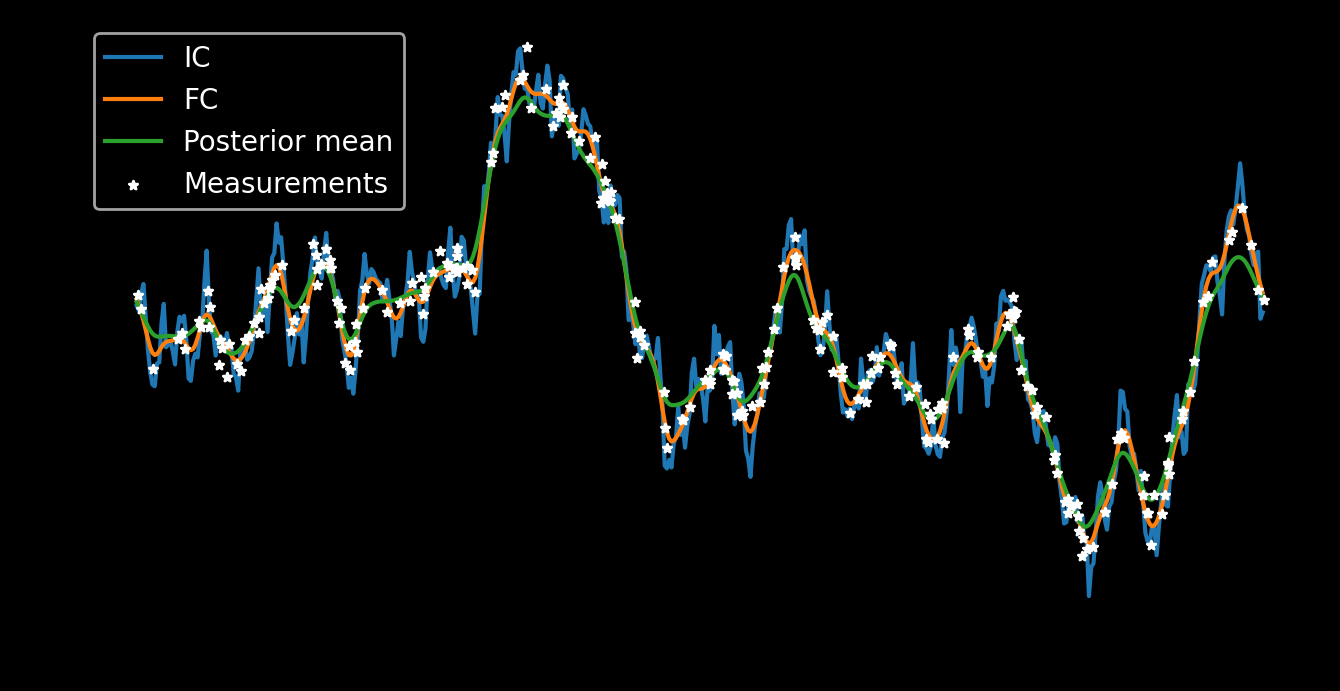

In [18]:
class Posterior(FourierMultiplier):
    ''' Based on Stuart 2.16a and 2.16b'''
    def __init__(self, data, fwd, obs, prior, sigSqr, **kwargs):
        super().__init__(**kwargs)
        O = obs.multiplier#.real
        F = fwd.multiplier#.real
        Sigma = prior.multiplier#.real       
        
        A = np.einsum('ij,j->ij', O, F)
        ASigma = np.einsum('ij, j->ij', A, Sigma)
        
        M = np.einsum('ij, kj-> ik', ASigma, A.conjugate())
        M = M + sigSqr * np.eye(*M.shape)

        #print(np.max(np.abs(O.imag)), np.max(np.abs(F.imag)), np.max(np.abs(Sigma.imag)))
        m = np.linalg.solve(M, data)
        m = np.einsum('ji, j->i', ASigma.conjugate(), m)
        m = self.to_time_domain(m)       
        self.m = m

        print(f'O {O.shape} F {F.shape} Sigma {Sigma.shape} A {A.shape} M {M.shape}')
meas = np.random.uniform(0, L, 250)
obs = PointObservation(meas=meas, L=L, N=N, transform=transform)
      
sig = 0.1
data = obs(uT) + np.random.normal(scale=sig, size=obs.size)
post = Posterior(data=data, fwd=fwd, obs=obs, prior=prior, sigSqr=sig**2, L=L, N=N, transform=transform)
        
plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='FC')
plt.scatter(obs.meas, data.real, label='Measurements', marker='*', s =10, color='w', zorder=10)
plt.plot(post.x, post.m, label='Posterior mean')


plt.legend()
#plt.close()

/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


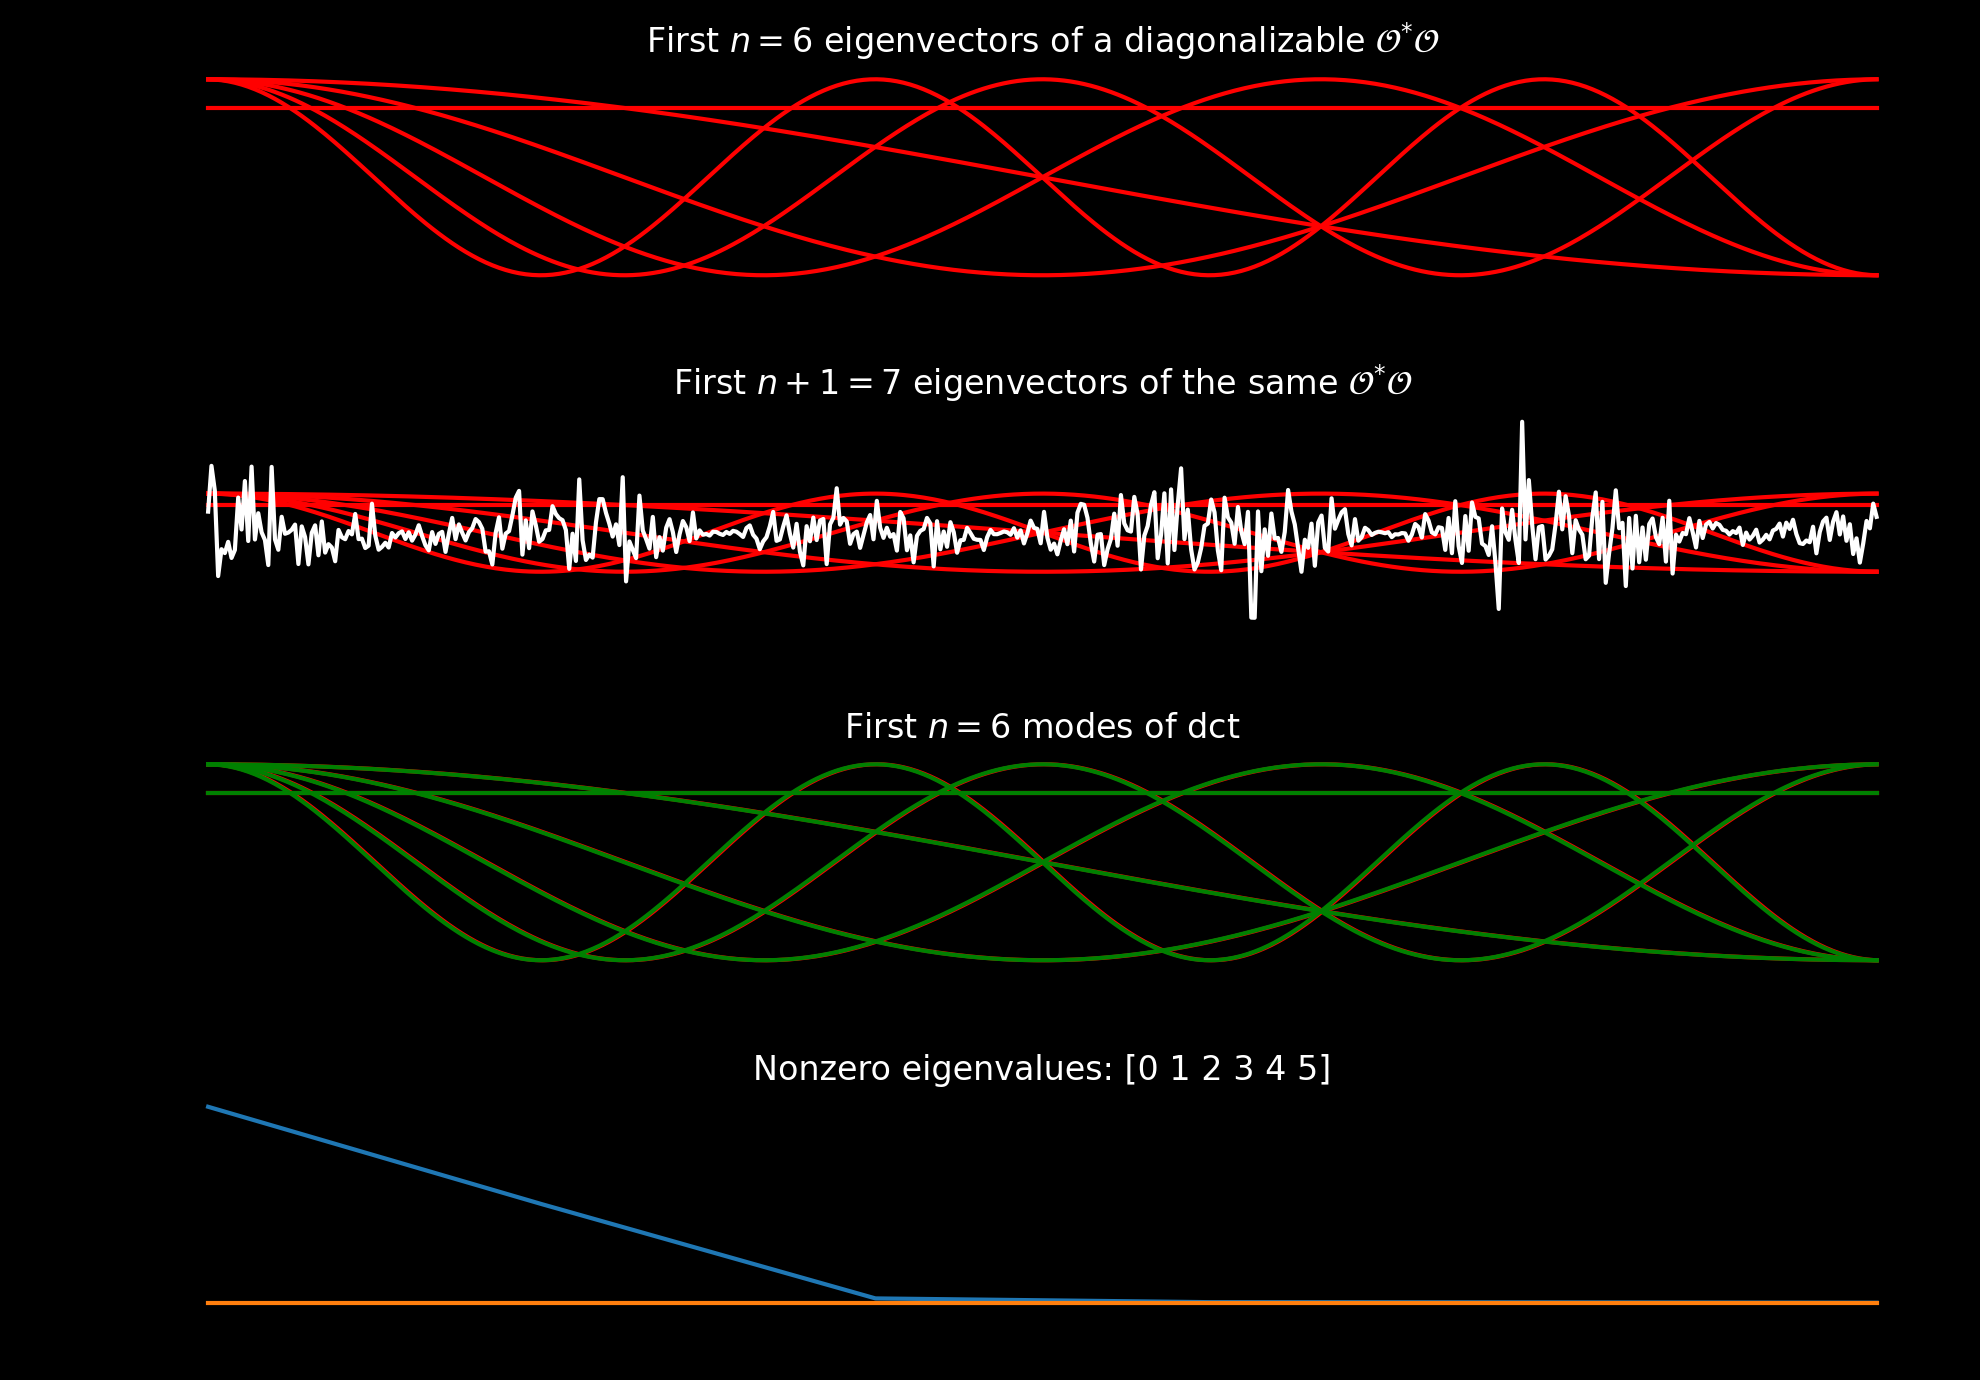

In [5]:
n = 6
singular_values = np.random.randn(n)**2
#singular_values[1] = 0
obs = DiagObservation(singular_values=singular_values,
                      N=500, 
                      random_U=True,
                      transform='dct')
D, P = np.linalg.eig(obs.OstarO)
P = np.einsum('ij, j -> ij', P, np.sign(P[0,:]))
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,7))
for i in range(n):
    ax[0].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[1].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[2].plot(obs.x, obs.eigenvector(i), label=f'True {i}', color='r')
ax[1].plot(obs.x, P[:,i+1], label='$n+1$', color='w')

for i in range(n):
    ax[2].plot(obs.x, P[:,i].real, color='g')


/
# for axi in ax:
#     axi.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#              ncol=1, fancybox=True, shadow=True)


OstarO = "$\mathcal{O}^{*}\mathcal{O}$"
ax[0].set_title(f"First $n={n}$ eigenvectors of a diagonalizable " + OstarO)
ax[1].set_title(f"First $n+1={n+1}$ eigenvectors of the same "  +OstarO)
ax[2].set_title(f"First $n={n}$ modes of {obs.transform}")


ind = np.where(np.abs(D) > 1e-9)[0]
ax[3].plot(np.arange(n), D[:n], label='$\mathbf{e}_i$')
ax[3].plot(np.arange(n), np.zeros(n), label='y=0')
ax[3].set_title(f"Nonzero eigenvalues: {ind}")

plt.tight_layout()
#plt.close()

In [6]:
fwd.eigenfunction(3)(np.array([4,5,4]))

array([-4.8985872e-16,  6.1232340e-16, -4.8985872e-16])